# Alternate Interpretations of DDPMs: Noise Predictor and Conditional Generation

**Goals for this notebook**

1. Define and derive the alternate interpretations of DDPMs.
2. Explain the noise-predictor formulation, where the model predicts $\epsilon_t$ given $x_t$ instead of $x_0$.
3. Show how computations are performed step by step.
4. Visualize the effect of noise and denoising with 2D/3D plots for better intuition.
5. Optionally, discuss conditional generation (e.g., class-conditioned MNIST) as an extension.


# DDPM as a Noise Predictor: Definition and Derivation

**Forward Diffusion Process:**
$$
q(x_t \mid x_0) = \mathcal{N}\big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) I \big), \quad \bar\alpha_t = \prod_{s=1}^{t} \alpha_s, \quad \alpha_s = 1-\beta_s
$$

**Alternate interpretation (Noise Predictor):**

Instead of directly predicting $x_0$ from $x_t$, the network predicts the noise $\epsilon_t$ that was added during the forward process:
$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\ \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0,I)
$$

Given $x_t$, the model predicts $\epsilon_\theta(x_t,t) \approx \epsilon_t$.

**Connection to denoising:**
Once $\epsilon_\theta(x_t,t)$ is predicted, $x_0$ can be recovered by:
$$
\hat x_0 = \frac{1}{\sqrt{\bar\alpha_t}} \left(x_t - \sqrt{1-\bar\alpha_t}\ \epsilon_\theta(x_t,t)\right)
$$

**Intuition:**
- Predicting $\epsilon_t$ instead of $x_0$ simplifies training and improves stability.
- The noise-predictor implicitly denoises $x_t$ by subtracting the estimated noise.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# MNIST loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_test = datasets.MNIST(root="mnist_data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist_test, batch_size=8, shuffle=False)

imgs, labels = next(iter(loader))
imgs = imgs.to(device)
print("Batch shape:", imgs.shape)


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]


Batch shape: torch.Size([8, 1, 28, 28])


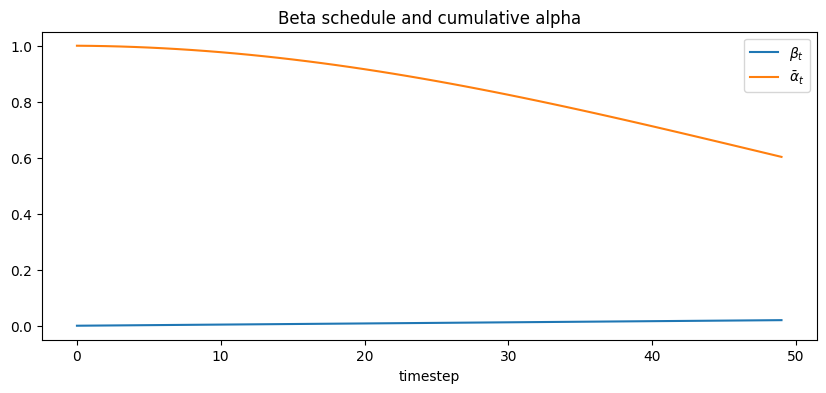

In [3]:
T = 50  # fewer steps for demonstration
beta_start, beta_end = 0.0001, 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

plt.figure(figsize=(10,4))
plt.plot(betas.cpu(), label=r'$\beta_t$')
plt.plot(alpha_bars.cpu(), label=r'$\bar\alpha_t$')
plt.xlabel("timestep")
plt.title("Beta schedule and cumulative alpha")
plt.legend()
plt.show()


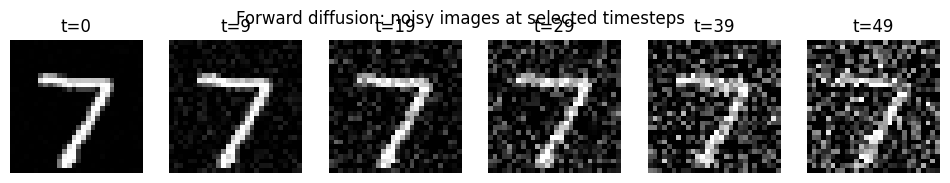

In [4]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = torch.sqrt(alpha_bars[t]).view(1,1,1,1).to(x0.device)
    sqrt_1_ab = torch.sqrt(1 - alpha_bars[t]).view(1,1,1,1).to(x0.device)
    return sqrt_ab * x0 + sqrt_1_ab * noise, noise

timesteps_viz = [0, 9, 19, 29, 39, 49]
noisy_imgs = []

for t in timesteps_viz:
    x_t, eps = q_sample(imgs[0:1], t)
    noisy_imgs.append((t, x_t.cpu().squeeze().numpy()))

fig, axes = plt.subplots(1, len(noisy_imgs), figsize=(12,2))
for i, (t, arr) in enumerate(noisy_imgs):
    axes[i].imshow(arr, cmap='gray', vmin=-1, vmax=1)
    axes[i].set_title(f"t={t}")
    axes[i].axis('off')
plt.suptitle("Forward diffusion: noisy images at selected timesteps")
plt.show()


In [5]:
class NoisePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )
    def forward(self, x, t=None):
        return self.net(x)

model = NoisePredictor().to(device)
model.eval()


NoisePredictor(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

x_t stats: -0.7870832681655884 0.5824912190437317
x0_hat stats: -0.831264078617096 0.6068403124809265


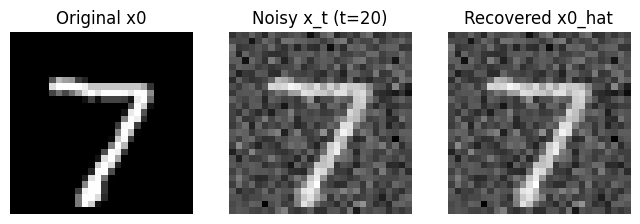

In [6]:
t_demo = 20
x_t, true_eps = q_sample(imgs[0:1], t_demo)
pred_eps = model(x_t)

x0_hat = (x_t - torch.sqrt(1-alpha_bars[t_demo])*pred_eps)/torch.sqrt(alpha_bars[t_demo])

print("x_t stats:", x_t.mean().item(), x_t.std().item())
print("x0_hat stats:", x0_hat.mean().item(), x0_hat.std().item())

# visualize
plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.imshow(imgs[0,0].cpu(), cmap='gray'); plt.title("Original x0"); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(x_t[0,0].cpu(), cmap='gray'); plt.title(f"Noisy x_t (t={t_demo})"); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(x0_hat[0,0].detach().cpu(), cmap='gray'); plt.title("Recovered x0_hat"); plt.axis('off')
plt.show()


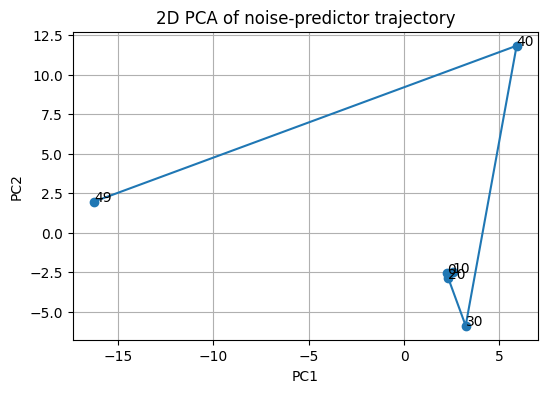

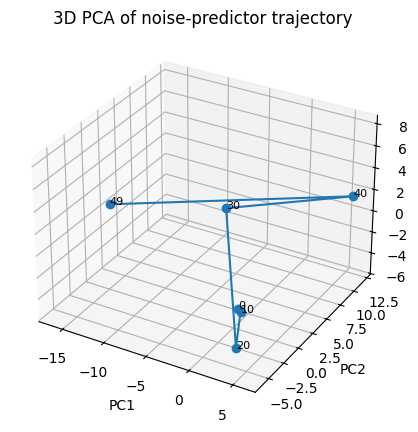

In [8]:
import numpy as np
# Collect flattened vectors for PCA
steps_demo = [0, 10, 20, 30, 40, 49]
vecs = []
for t in steps_demo:
    x_t, _ = q_sample(imgs[0:1], t)
    vecs.append(x_t.cpu().reshape(-1))
vecs = np.stack(vecs)

pca = PCA(n_components=3)
proj = pca.fit_transform(vecs)

# 2D trajectory
plt.figure(figsize=(6,4))
plt.plot(proj[:,0], proj[:,1], marker='o')
for i, (x,y,z) in enumerate(proj):
    plt.text(x,y,str(steps_demo[i]))
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('2D PCA of noise-predictor trajectory')
plt.grid(True)
plt.show()

# 3D trajectory
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(proj[:,0], proj[:,1], proj[:,2], marker='o')
for i, (x,y,z) in enumerate(proj):
    ax.text(x,y,z,str(steps_demo[i]), size=8)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('3D PCA of noise-predictor trajectory')
plt.show()


# Summary

1. In this interpretation, DDPM predicts the noise $\epsilon_t$ rather than $x_0$ directly.
2. Predicting $\epsilon_t$ simplifies the learning task and stabilizes training.
3. Given predicted noise, we can reconstruct $\hat x_0$ using
   $$
   \hat x_0 = \frac{x_t - \sqrt{1-\bar\alpha_t}\ \epsilon_\theta(x_t,t)}{\sqrt{\bar\alpha_t}}.
   $$
4. Visualizations show the forward-noising trajectory and how noise subtraction moves the sample back toward the data manifold.
5. This forms the basis for conditional generation, where the predictor can also receive additional conditioning information (e.g., class label or text embedding).
